In [1]:
import numpy as np
import time
import pandas as pd
from scipy.sparse import csr_matrix
from netreco import Reconstructor, ss_sim
from netreco.Reconstructor import Profile
import matplotlib.pyplot as plt

R = 100

In [2]:
A = [
    [0.75, 0, 0, 0, 0, 1.2],
    [-.1, -.35, 0, 0, 0, 0],
    [0, 0, .85, -1, 0, 0],
    [0, -.73, 0, .95, 0, 0],
    [0, 0, .43, 0, -.6, 0],
    [0, 0, 0, 0, .2, .55]

]
A = np.array(A)
B = [
    [1.4, 0, 0],
    [0, -.25, 0],
    [0, 0, 0.75],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0]
]
B = np.array(B)
C = [
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0]
]
C = np.array(C)

# u = pd.read_csv('../scripts/u.csv', header=None).values
u = np.random.rand(R * 6 + 1, 3)
y = ss_sim(A, B, C, u)

Pbool = np.identity(3)

recon = Reconstructor(debug=True)
# recon.measured(y, u, R, Pbool=Pbool, max_iterations=1000, bounds=3)

Setting up ...
	Done. Took 0.000 Seconds
Building LQ ...
	Done. Took 0.135 Seconds
Building LP ...
	Done. Took 0.139 Seconds
Building M ...
	Done. Took 0.190 Seconds
Building yhat ...
	Done. Took 0.000 Seconds
Running Least Squares for yhat = M*xhat ...
	Finished lsq: 2
	Done. Took 1.666 Seconds
Building Qi's ...
	Done. Took 0.001 Seconds
Learning Convolution for Q(1,3) ...
	Done. Took 3.630 Seconds


Exception: Could not find Q_1,3 in 10 iterations

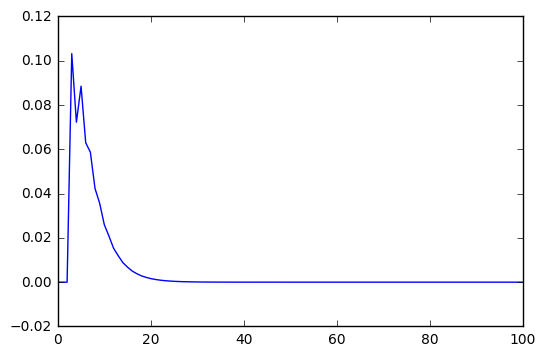

In [3]:
% matplotlib inline
r = R
kwargs = dict(Pbool=Pbool, max_iterations=10, bounds=3)

beginning = time.time()

with Profile(recon.debug, 'Setting up'):
    recon.robust = kwargs.get('robust', False)
    recon.alpha = kwargs.get('alpha', 1)
    recon.T22 = kwargs.get('T22', None)
    recon.Pbool = kwargs.get('Pbool', None)
    recon.order = kwargs.get('order', 3)
    recon.bounds = kwargs.get('bounds', 10)
    recon.test_params = kwargs.get('test_params', False)

    if recon.test_params:
        recon.max_iterations = 1
    else:
        recon.max_iterations = kwargs.get('max_iterations', 10)

    f, p = y.shape
    f1, m = u.shape

    assert f == f1
    assert not (recon.Pbool is None and recon.T22 is None)

    recon.p = p
    recon.m = m
    recon.f = f

    r = min(r, f - 1)
    recon.r = r

    if recon.T22 is None:
        p1, m1 = recon.Pbool.shape
        assert p == p1
        assert m == m1
        recon.T22 = recon._build_T22(recon.Pbool)
        ps = p1 * m1 - len(recon.T22)
    else:
        pm, l = recon.T22.shape
        assert p*m == pm
        # Need to convert to to ignore list
        raise Exception('Not implemented')

with Profile(recon.debug, 'Building LQ'):
    rows, cols, data = recon._build_LQ(y)
    # LQ = csr_matrix((np.concatenate(data),
    #                  (np.concatenate(rows),
    #                   np.concatenate(cols))
    #                  ),
    #                 ((recon.f - 1) * recon.p,
    #                  recon.r * (recon.p * recon.p - recon.p)))
    # print(LQ.shape)
    # print(LQ.toarray())

with Profile(recon.debug, 'Building LP'):
    # rows = []
    # cols = []
    # data = []
    # col_offset = 0
    col_offset = recon.r * (recon.p * recon.p - recon.p)
    rows, cols, data = recon._build_LP(u, recon.T22, rows, cols, data,
                                       col_offset)
    # LP = csr_matrix((np.concatenate(data),
    #                   (np.concatenate(rows),
    #                    np.concatenate(cols))
    #                   ),
    #                  ((recon.f - 1) * recon.p,
    #                   recon.r * ps))
    # print(LP.shape)
    # print(LP.toarray())

with Profile(recon.debug, 'Building M'):
    M = csr_matrix((np.concatenate(data),
                    (np.concatenate(rows),
                     np.concatenate(cols))
                    ),
                   ((recon.f - 1) * recon.p,
                    recon.r * (ps + recon.p * recon.p - recon.p)))

with Profile(recon.debug, 'Building yhat'):
    yhat = recon._build_yhat(y)

with Profile(recon.debug, 'Running Least Squares for yhat = M*xhat'):
    xhat = recon._run_lsq(M, yhat)

with Profile(recon.debug, 'Building Qi\'s'):
    Qis = recon._extract_Qis(xhat)

plt.figure()
plt.plot(list(range(recon.r + 1)), Qis[0][2])

for i in range(recon.p):    
    for j in range(recon.p):
        recon._fit_conv(Qis, i, j)

recon.dprint('\nReconstruction Complete! Took {:.3f} Seconds\n'.format(
    time.time() - beginning
))


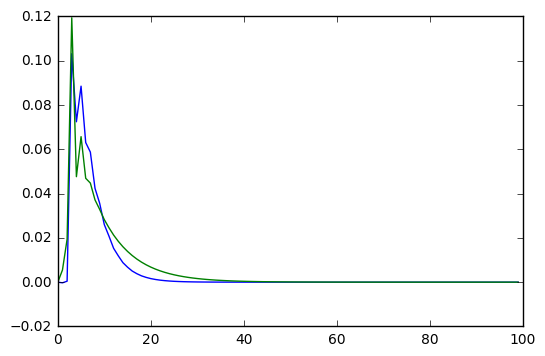

In [5]:
def act(t):
    if t == 0:
        return 0
    
    return .51*(.75)**t -.11*(-.6)**t - .816*(.55)**t

def fit(t):
    if t == 0:
        return 0
    
    return 0.118*(0.867)**t + -0.776*(-0.401)**t + 3.000*(-0.136)**t

t = list(range(100))
# plt.plot(list(range(recon.r + 1)), Qis[0][2], marker='--')
plt.plot(t, [act(ti) for ti in t])
plt.plot(t, [fit(ti) for ti in t])

In [42]:
def fiterr(params, act, plot=False):
    n = len(act)
    exp = np.zeros(n)
    for t in range(1, n):
        for i in range(int(len(params) / 2)):
            exp[t] += params[i * 2] * params[i * 2 + 1] ** t
            
    err = abs(np.array(act) - exp)
    if plot:
        plt.figure()
        plt.plot(range(n), act)
        plt.plot(range(n), exp)
        plt.title('Exp (b) vs Act (g)')
    
        plt.figure()
        plt.plot(range(n), err)
        plt.title('Errors')
        
    toterr = sum(err)
    # print(toterr)
    return toterr
    
with Profile(True, 'fit'):
    err = fiterr([0.118, 0.867, -.776, -.401, 3, -.136], Qis[0][2])
    print(err)
    err = fiterr([0, 0, 0, 0, 0, 0], Qis[0][2])
    print(err)
    err = fiterr([.51, .75, -.11, -.6, -.816, .55], Qis[0][2])
    print(err)

fit ...
0.229477428769
0.573336762889
0.00127887605421
	Done. Took 0.002 Seconds


In [32]:
from scipy.optimize import minimize
from functools import partial

obj = partial(fiterr, act=Qis[0][2])
# print(obj)

methods = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'Newton-CG', 'L-BFGS-B',
           'TNC', 'COBYLA', 'SLSQP', 'dogleg', 'trust-ncg']
runs = 20
data = {}
for method in methods:
    print('Running {}'.format(method))
    data[method] = {}
    for run in range(runs):
        rs = minimize(obj, np.random.random(6), method='Nelder-Mead')
        data[method]['Run_{}'.format(run)] = rs['fun']

df = pd.DataFrame(data).transpose()

Running Nelder-Mead
Running Powell
Running CG
Running BFGS
Running Newton-CG
Running L-BFGS-B
Running TNC
Running COBYLA
Running SLSQP
Running dogleg
Running trust-ncg


In [34]:
print('Best Run')
print(df.min(axis=1))
print('Worst Run')
print(df.max(axis=1))
print('Average Run')
print(df.mean(axis=1))

Best Run
BFGS           0.115988
CG             0.067974
COBYLA         0.098174
L-BFGS-B       0.085507
Nelder-Mead    0.026269
Newton-CG      0.050233
Powell         0.085215
SLSQP          0.137529
TNC            0.074983
dogleg         0.058504
trust-ncg      0.112793
dtype: float64
Worst Run
BFGS           0.584966
CG             0.587554
COBYLA         0.575834
L-BFGS-B       0.574025
Nelder-Mead    0.573672
Newton-CG      0.603554
Powell         0.586433
SLSQP          0.574402
TNC            0.574294
dogleg         0.583006
trust-ncg      0.577820
dtype: float64
Average Run
BFGS           0.344362
CG             0.218656
COBYLA         0.300975
L-BFGS-B       0.327050
Nelder-Mead    0.298497
Newton-CG      0.323964
Powell         0.334885
SLSQP          0.300517
TNC            0.267101
dogleg         0.287353
trust-ncg      0.317065
dtype: float64


In [37]:
from scipy.optimize import basinhopping
rs = basinhopping(obj, np.random.random(6))
print(rs)

RuntimeWarning: overflow encountered in double_scalars

     fun: 6.3618361717363789e-06
     jac: array([-0.  , -0.  ,  0.59,  2.02,  1.16,  0.29,  0.85,  0.69])
 message: 'Optimization terminated successfully.'
    nfev: 96477
     nit: 802
 success: True
       x: array([-0.  , -0.  , -0.82,  0.55, -0.11, -0.6 ,  0.51,  0.75])


6.3618361717363789e-06

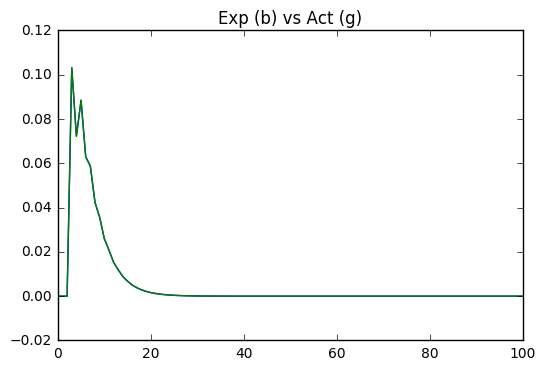

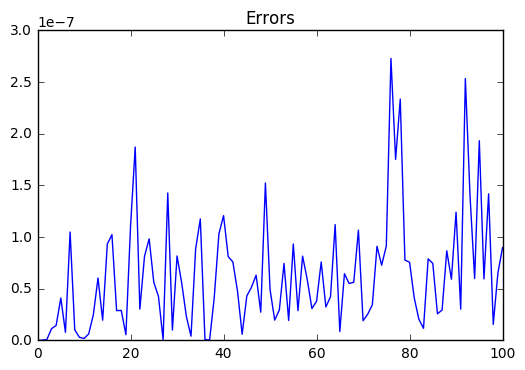

In [47]:
from scipy.optimize import differential_evolution
rs = differential_evolution(obj, bounds=[(-10, 10), (-1, 1), (-10, 10), (-1, 1), (-10, 10), (-1, 1), (-10, 10), (-1, 1)])
print(rs)
fiterr(rs.x, Qis[0][2], True)

28.262698253145491

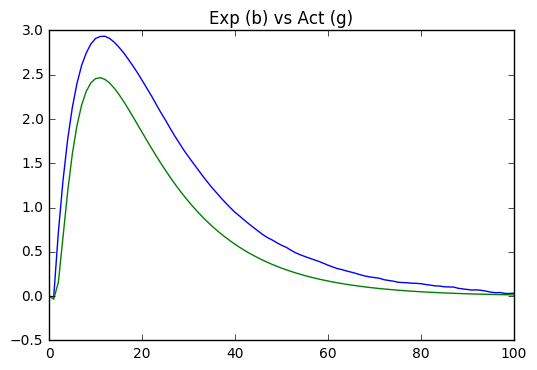

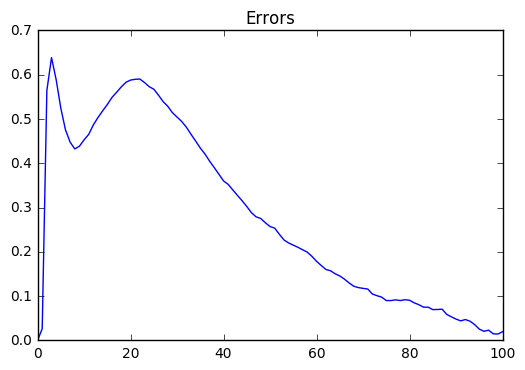

In [51]:
fiterr([-3.86,  0.21,  7.27,  0.28, -9.56,  0.82,  7.  ,  0.94], Qis[2][1], True)